# Building a Robot Judge 2019 - Problem Set
Author: Simon Schaefer

### Problem Set I

In [1]:
import glob
import os
import pandas

# Loading text data and reversed flags to dataframe. The data are assumed to be in 
# the DATA_PATH directory, i.e. the description file as "case_reversed.csv" and the 
# texts in the subdirectory "cases/". 
DATA_PATH = "../data/"
cases_df  = pandas.read_csv(DATA_PATH + "case_reversed.csv") 
cases_df  = cases_df.sample(n=min(250, len(cases_df)))  # due to low performance of my laptop
cases_df  = cases_df.sort_index()
texts, years = [], []
for x in cases_df['caseid']: 
    file_path = glob.glob(DATA_PATH + "cases/*" + str(x) + ".txt")
    assert len(file_path) == 1
    file_path = file_path[0]
    f = open(file_path, 'r')
    texts.append(f.read())
    years.append(int(file_path[14:18])) # 14 = len(DATA_PATH+"cases/")
cases_df['text'] = texts
del texts, years
cases_df.head()

,caseid,case_reversed,text
15,X3JGK4,0,"HOUGH , Circuit Judge (after stating the fact..."
62,X3FTBS,0,"ROBB , Associate Justice.\nThe Act of March 1..."
81,X3GGH5,0,"VAN VALKENBURGH , Circuit Judge.\nThe Minneap..."
83,X3GPDN,0,"ROBB , Associate Justice.\nWrit of error to t..."
97,X3GMPD,0,"SYMES , District Judge.\nThis is an appeal fr..."


Use spaCy to process all cases. Split the documents into sentences and tokens. Compute number of sentences, words, and letters for each document. Report histograms for these statistics.

In [2]:
import spacy

nlp = spacy.load('en')

def count_sents_words_letters(x): 
    doc = nlp(x)
    sentences = list(doc.sents)
    tokens    = [t for t in doc]
    words     = [t for t in tokens if t.is_alpha]
    #numbers   = [t for t in tokens if t.is_digit]    
    return len(sentences), len(words), sum([len(w) for w in words])
    
cases_df['num_sents'], cases_df['num_words'], cases_df['num_letts'] = zip(*cases_df['text'].map(count_sents_words_letters))
cases_df.head()

,caseid,case_reversed,text,num_sents,num_words,num_letts
15,X3JGK4,0,"HOUGH , Circuit Judge (after stating the fact...",43,1044,4935
62,X3FTBS,0,"ROBB , Associate Justice.\nThe Act of March 1...",98,1994,9623
81,X3GGH5,0,"VAN VALKENBURGH , Circuit Judge.\nThe Minneap...",190,4356,21346
83,X3GPDN,0,"ROBB , Associate Justice.\nWrit of error to t...",105,2461,11478
97,X3GMPD,0,"SYMES , District Judge.\nThis is an appeal fr...",119,2501,11742


In [3]:
import matplotlib.pyplot as plt

cases_df.hist(label='caseid')
plt.show()

<Figure size 640x480 with 4 Axes>

Use the spaCy parts of speech (POS) tags to count number of nouns, verbs, and adjectives in each document. Visualize POS frequency by year.

In [4]:
def poses(x): 
    doc = nlp(x)
    poses = {'NOUN': 0, 'VERB': 0, 'ADJ': 0}
    for token in doc: 
        pos = token.pos_
        if pos in poses.keys(): 
            poses[pos] += 1
    return poses['NOUN'], poses['VERB'], poses['ADJ']
    
cases_df['num_nouns'], cases_df['num_verbs'], cases_df['num_adjs'] = zip(*cases_df['text'].map(poses))
cases_df.head()

,caseid,case_reversed,text,num_sents,num_words,num_letts,num_nouns,num_verbs,num_adjs
15,X3JGK4,0,"HOUGH , Circuit Judge (after stating the fact...",43,1044,4935,205,221,76
62,X3FTBS,0,"ROBB , Associate Justice.\nThe Act of March 1...",98,1994,9623,460,359,90
81,X3GGH5,0,"VAN VALKENBURGH , Circuit Judge.\nThe Minneap...",190,4356,21346,959,637,300
83,X3GPDN,0,"ROBB , Associate Justice.\nWrit of error to t...",105,2461,11478,567,382,218
97,X3GMPD,0,"SYMES , District Judge.\nThis is an appeal fr...",119,2501,11742,595,394,102


Follow the steps in lecture to normalize your corpus (e.g., removing punctuation) and discuss your choices about what information to exclude. Using the normalized tokens, make a feature set of all trigrams that end in a noun.

In [5]:
# Non-alphanumeric tokens do not contain any statistical information (after splitting to tokens)
# and can therefore be removed. As shown above most of the digits in the dataframe have similar 
# scale and are therefore replaced by a common signs. 
def normalize_text(x): 
    doc = nlp(x)
    tokens = [t for t in doc if ((t.is_alpha or t.is_digit) and not t.is_stop)]
    tokens = ["%" if t.is_digit else t.lemma_ for t in tokens]
    tokens = [str(t).lower() for t in tokens]
    return tokens

cases_df['normalized'] = cases_df['text'].apply(normalize_text)
cases_df.head()

,caseid,case_reversed,text,num_sents,num_words,num_letts,num_nouns,num_verbs,num_adjs,normalized
15,X3JGK4,0,"HOUGH , Circuit Judge (after stating the fact...",43,1044,4935,205,221,76,"[hough, circuit, judge, state, fact, make, fac..."
62,X3FTBS,0,"ROBB , Associate Justice.\nThe Act of March 1...",98,1994,9623,460,359,90,"[robb, associate, justice, act, march, %, %, %..."
81,X3GGH5,0,"VAN VALKENBURGH , Circuit Judge.\nThe Minneap...",190,4356,21346,959,637,300,"[van, valkenburgh, circuit, judge, minneapolis..."
83,X3GPDN,0,"ROBB , Associate Justice.\nWrit of error to t...",105,2461,11478,567,382,218,"[robb, associate, justice, writ, error, police..."
97,X3GMPD,0,"SYMES , District Judge.\nThis is an appeal fr...",119,2501,11742,595,394,102,"[symes, district, judge, appeal, decision, uni..."


Make a dataframe with at least 1000 features (frequencies over trigrams ending in a noun). Standardize the features to variance one while maintaining sparsity.

In [6]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

trigrams = []
for x in cases_df['text']:
    tokens = x.lower().split() 
    trigrams += list(ngrams(tokens,3)) 
trigrams = Counter(trigrams).most_common()[:1000] 
trigrams = dict(trigrams)

trigrams_freq = []
for x in cases_df['text']:
    freq = {str(key): 0 for key in trigrams.keys()}
    tokens = x.lower().split() 
    grams  = list(ngrams(tokens,3)) 
    for g in grams: 
        if g in trigrams.keys(): 
            freq[str(g)] += 1
    trigrams_freq.append(freq)

trigram_df = pandas.DataFrame(trigrams_freq)
for column in trigram_df:
    var = trigram_df.loc[:,column].var()
    trigram_df[column] = trigram_df[column]/var
trigram_df.head()

,"(""court's"", 'decision', 'in')","(""court's"", 'denial', 'of')","(""court's"", 'grant', 'of')","('(c.', 'c.', 'a.')","('(c.', 'c.', 'a.)')","('(internal', 'quotation', 'marks')","(',', '100', 's.ct.')","(',', '101', 's.ct.')","(',', '102', 's.ct.')","(',', '103', 's.ct.')",...,"('with', 'respect', 'to')","('with', 'the', 'district')","('with', 'this', 'opinion.')","('within', 'the', 'meaning')","('within', 'the', 'scope')","('would', 'have', 'been')","('would', 'not', 'be')","('would', 'not', 'have')","('writ', 'of', 'habeas')","('years', 'after', 'the')"
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,2.039312,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,10.269227,0.000000,0.0,0.0,0.0,0.0,0.0,...,2.47726,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,5.971796
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.772946,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.000000,5.331449,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,23.887183


Link the dataframe to the outcome ​reverse. ​Create a training set and test set. Train a LogisticRegression​ model with default parameters to predict reversal. Compute accuracy and F1 for the prediction in the training set and in the test set.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Create training and test frame. 
x_train, x_test, y_train, y_test = train_test_split(trigram_df, 
                                                    cases_df['case_reversed'], 
                                                    test_size=0.2)

# Fit logistic regression model with default params. 
model = LogisticRegression(solver="liblinear").fit(x_train, y_train)

# Predict training and test set. 
score_train = model.score(x_train, y_train)
score_test  = model.score(x_test, y_test)
print("Train: {}, Test: {}".format(score_train, score_test))

Train: 0.995, Test: 0.44


Use ​GridSearchCV()​ to choose hyperparameters: L1 vs L2 penalty, and regularization parameter C. Report the best model parameters and score.


In [8]:
import numpy as np
from sklearn.model_selection import GridSearchCV

grid      = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
model     = LogisticRegression(solver="liblinear")
logreg_cv = GridSearchCV(model, grid, cv=2)
logreg_cv.fit(x_train, y_train)
print("Best hpyerparameters: ", logreg_cv.best_params_)
print("Best score:", logreg_cv.best_score_)

Best hpyerparameters:  {'C': 0.001, 'penalty': 'l2'}
Best score: 0.585


/Users/Sele/Documents/Projects/robot_judge/brj_venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Make a new dataframe where each document is a sentence. Compute ​vader​ compound sentiment scores for each sentence and report the top 10 highest- and lowest-sentiment sentences.

In [9]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
sentences = []
for x in cases_df['text']: 
    doc = nlp(x)
    sentences += [str(s) for s in doc.sents]
polarities = {}
for sentence in sentences:
    ss = sid.polarity_scores(sentence)
    compound = ss["compound"] 
    if not (compound is None or sentence is None): 
        polarities[sentence] = compound
polarities_sorted = sorted(polarities.items(), key=lambda kv: kv[1])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Sele/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
#print("Lowest sentiments")
#polarities_sorted[:10]

In [11]:
#print("Highest sentiments")
#polarities_sorted[len(polarities_sorted)-10:]

Use ​TfidfVectorizer​ to compute tf-idf frequencies for each sentence, and then compute cosine similarities​ between all sentences. Report example pairs of very similar sentences and very dissimilar sentences.

In [12]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=0.9,  # at most 90% of docs
                        max_features=1000,
                        stop_words='english',
                        use_idf=True)

X_tfidf = tfidf.fit_transform(sentences)
tsim = cosine_similarity(X_tfidf)
similar = np.argmax(tsim - np.eye(tsim.shape[0]), axis=0)
#print("Similiar: \n{}\n{}".format(sentences[0], sentences[similar[0]]))
dissimilar = np.argmin(tsim, axis=0)
#print("Dissimiliar: \n{}\n{}".format(sentences[0], sentences[dissimilar[0]]))

Use k-means clustering to assign the sentences into 20 clusters. List 5 example sentences from each cluster.

In [13]:
from sklearn.cluster import KMeans

num_clusters = 4
km = KMeans(n_clusters=num_clusters,n_jobs=-1)
km.fit(X_tfidf)

cluster_dict = {x: [] for x in range(num_clusters)}
for i, c in enumerate(km.labels_.tolist()): 
    cluster_dict[c].append(sentences[i])
cluster_numel = [len(x) for x in cluster_dict.values()]
print("Number of elements allocated to each cluster: " + str(cluster_numel))
#for k,v in cluster_dict.items(): 
#    print("\n\nCluster {}: \n{}\n{}\n{}\n{}\n{}".format(k, v[0],v[1],v[2],v[3],v[4]))

Number of elements allocated to each cluster: [33133, 2147, 1520, 1918]


### Problem Set II

In [14]:
import pandas

# Loading updated cases metadata file and merge with already existing dataframe. 
# As sampled rows of cases_df are sorted the order is maintained. 
DATA_PATH     = "../data/"
cases_meta_df = pandas.read_csv(DATA_PATH + "case_metadata.csv") 
cases_meta_df = cases_meta_df.loc[cases_meta_df['caseid'].isin(cases_df['caseid'].tolist())]
cases_meta_df['text'] = cases_df['text']
cases_meta_df = cases_meta_df.reset_index()

na_index = cases_meta_df['log_cites'].index[cases_meta_df['log_cites'].apply(np.isnan)]
cases_meta_df   = cases_meta_df.drop(na_index)
trigram_meta_df = trigram_df.drop(na_index)
cases_meta_df.head()

,index,caseid,case_reversed,judge_id,year,log_cites,text
2,81,X3GGH5,0,2131.0,1929.0,1.945910,"VAN VALKENBURGH , Circuit Judge.\nThe Minneap..."
4,97,X3GMPD,0,2029.0,1929.0,1.386294,"SYMES , District Judge.\nThis is an appeal fr..."
5,115,X9VBEC,0,1549.0,1930.0,1.791759,"NORCROSS , District Judge.\nThis is an appeal..."
7,150,X3S7NU,0,2131.0,1932.0,1.609438,"VAN VALKENBURGH , Circuit Judge.\nThe Great N..."
8,171,X3VTE8,0,1554.0,1932.0,1.386294,"NORTHCOTT , Circuit Judge.\nThis is a petitio..."


Take your best-performing logistic regression model from Problem Set 1 (or train a new one). Use cross_val_predict() to form model predictions for each observation. Construct a confusion matrix for the predictions. Report the precision_recall_curve() and roc_curve(). Make a calibration plot (as in Bansak et al 2018, appendix page 24).


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, train_test_split

# Create training and test frame. 
x_train, x_test, y_train, y_test = train_test_split(trigram_meta_df, 
                                                    cases_meta_df['case_reversed'], 
                                                    test_size=0.2)

# Fit logistic regression model with default params. 
model = LogisticRegression(solver="liblinear").fit(x_train, y_train)

# Predict training and test set. 
score_train = model.score(x_train, y_train)
score_test  = model.score(x_test, y_test)
print("Train: {}, Test: {}".format(score_train, score_test))

# Prediction for each observation. 
cases_meta_df['reversed_pred'] = cross_val_predict(
    model, X=trigram_meta_df, y=cases_meta_df['case_reversed'], cv=2)
cases_meta_df.head()

Train: 1.0, Test: 0.6111111111111112


,index,caseid,case_reversed,judge_id,year,log_cites,text,reversed_pred
2,81,X3GGH5,0,2131.0,1929.0,1.945910,"VAN VALKENBURGH , Circuit Judge.\nThe Minneap...",1
4,97,X3GMPD,0,2029.0,1929.0,1.386294,"SYMES , District Judge.\nThis is an appeal fr...",0
5,115,X9VBEC,0,1549.0,1930.0,1.791759,"NORCROSS , District Judge.\nThis is an appeal...",1
7,150,X3S7NU,0,2131.0,1932.0,1.609438,"VAN VALKENBURGH , Circuit Judge.\nThe Great N...",1
8,171,X3VTE8,0,1554.0,1932.0,1.386294,"NORTHCOTT , Circuit Judge.\nThis is a petitio...",1


In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(cases_meta_df['case_reversed'], cases_meta_df['reversed_pred'])

array([[15, 50],
       [26, 89]])

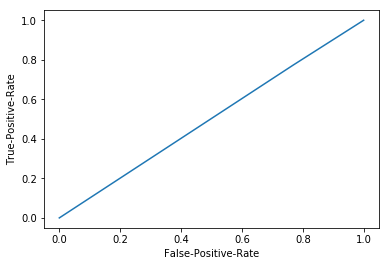

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(cases_meta_df['case_reversed'], 
                                          cases_meta_df['reversed_pred'])
plt.plot(fpr, tpr)
plt.xlabel("False-Positive-Rate")
plt.ylabel("True-Positive-Rate")
plt.show()

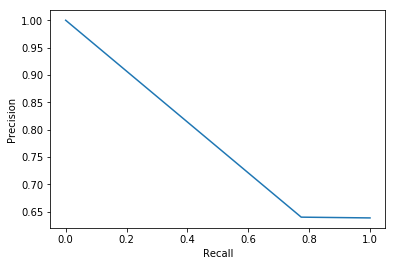

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(cases_meta_df['case_reversed'], 
                                                       cases_meta_df['reversed_pred'])
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

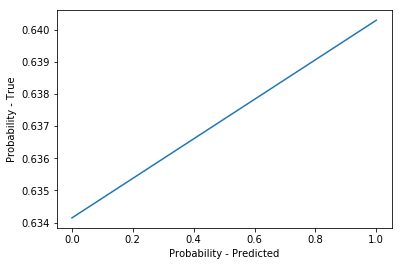

In [19]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(cases_meta_df['case_reversed'], 
                                         cases_meta_df['reversed_pred'])
plt.plot(prob_pred, prob_true)
plt.xlabel("Probability - Predicted")
plt.ylabel("Probability - True")
plt.show()

Scale your n-gram frequencies while maintaining sparsity, as discussed in class. Train an elastic net model to predict log citations to a case (log_cites). Run cross_val_predict() to form model predictions and report a scatter plot of true and predicted values. 


In [20]:
from sklearn.linear_model import ElasticNet

# Create training and test frame. 
x_train, x_test, y_train, y_test = train_test_split(trigram_meta_df, 
                                                    cases_meta_df['log_cites'], 
                                                    test_size=0.2)

# Fit elastic net model with default params. 
model = ElasticNet().fit(x_train, y_train)

# Prediction for each observation. 
cases_meta_df['logcites_pred'] = cross_val_predict(
    model, X=trigram_meta_df, y=cases_meta_df['log_cites'], cv=2)
cases_meta_df.head()

,index,caseid,case_reversed,judge_id,year,log_cites,text,reversed_pred,logcites_pred
2,81,X3GGH5,0,2131.0,1929.0,1.945910,"VAN VALKENBURGH , Circuit Judge.\nThe Minneap...",1,2.341558
4,97,X3GMPD,0,2029.0,1929.0,1.386294,"SYMES , District Judge.\nThis is an appeal fr...",0,2.054207
5,115,X9VBEC,0,1549.0,1930.0,1.791759,"NORCROSS , District Judge.\nThis is an appeal...",1,2.059050
7,150,X3S7NU,0,2131.0,1932.0,1.609438,"VAN VALKENBURGH , Circuit Judge.\nThe Great N...",1,2.054207
8,171,X3VTE8,0,1554.0,1932.0,1.386294,"NORTHCOTT , Circuit Judge.\nThis is a petitio...",1,2.213935


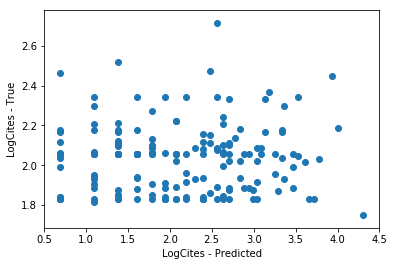

In [21]:
import matplotlib.pyplot as plt
plt.scatter(cases_meta_df['log_cites'], cases_meta_df['logcites_pred'])
plt.xlabel("LogCites - Predicted")
plt.ylabel("LogCites - True")
plt.show()

Use the judge identifiers (judge_id) to produce the average citations to cases for each judge. Then estimate a two-stage least-squares model with Z as average citations of the judge, X as citations to the case, and Y as whether the case was reversed. Include year fixed effects. Report estimates for coefficient and standard error on X.

In [22]:
from linearmodels.iv import IV2SLS
import numpy as np

judge_cites = {}
for _, row in cases_meta_df.iterrows():
    judge_id = row['judge_id']
    if not judge_id in judge_cites.keys(): judge_cites[judge_id] = []
    judge_cites[judge_id].append(row['log_cites'])
judge_cites = {jid: np.mean(x) for jid, x in judge_cites.items()}

def look_up_mean_cites(x): 
    return judge_cites[x]

cases_meta_df['avg_cites_judge'] = cases_meta_df['judge_id'].apply(look_up_mean_cites)
cases_meta_df.head()

,index,caseid,case_reversed,judge_id,year,log_cites,text,reversed_pred,logcites_pred,avg_cites_judge
2,81,X3GGH5,0,2131.0,1929.0,1.945910,"VAN VALKENBURGH , Circuit Judge.\nThe Minneap...",1,2.341558,1.777674
4,97,X3GMPD,0,2029.0,1929.0,1.386294,"SYMES , District Judge.\nThis is an appeal fr...",0,2.054207,1.386294
5,115,X9VBEC,0,1549.0,1930.0,1.791759,"NORCROSS , District Judge.\nThis is an appeal...",1,2.059050,1.791759
7,150,X3S7NU,0,2131.0,1932.0,1.609438,"VAN VALKENBURGH , Circuit Judge.\nThe Great N...",1,2.054207,1.777674
8,171,X3VTE8,0,1554.0,1932.0,1.386294,"NORTHCOTT , Circuit Judge.\nThis is a petitio...",1,2.213935,1.386294


In [23]:
# Two-stage least-squares model. 
#iv = IV2SLS(dependent=cases_meta_df['case_reversed'],
#            exog=cases_meta_df['log_cites'],
#            endog=cases_meta_df['avg_cites_judge'], 
#            instruments=cases_meta_df['year']).fit()

#print(iv.summary)

Train LDA on the cases. Produce word clouds for the topics. Inspect the word clouds for different models to decide on the right number of topics.


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy

# Prepare word in dataframe to tf-idf-shape. 
nlp = spacy.load('en')
sentences = []
for x in cases_meta_df['text']: 
    doc = nlp(x)
    sentences += [str(s) for s in doc.sents]

# LDA can only use raw term counts.
tf_vectorizer = CountVectorizer(min_df=0.01, # at min 1% of docs
                                max_df=0.9,  # at most 90% of docs 
                                max_features=1000, 
                                stop_words='english')
Xtf       = tf_vectorizer.fit_transform(sentences)
Xtf_names = tf_vectorizer.get_feature_names()

LDA with 2 topics


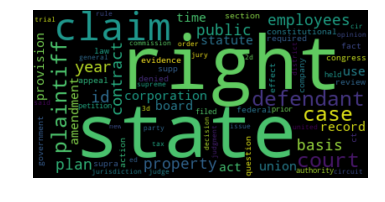

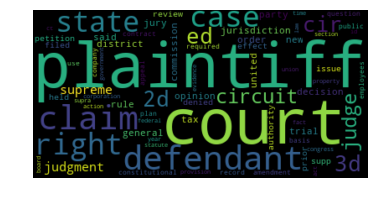

LDA with 5 topics


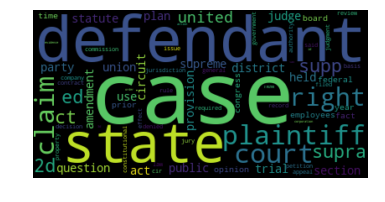

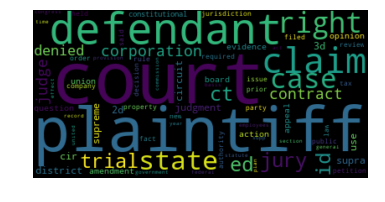

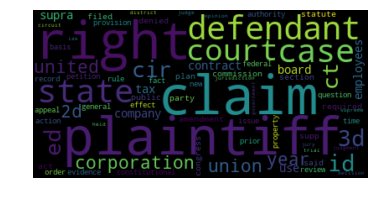

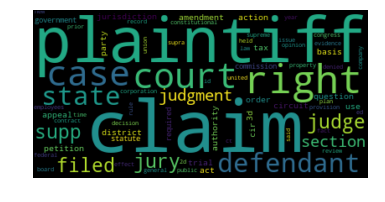

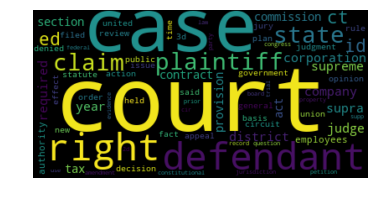

LDA with 10 topics


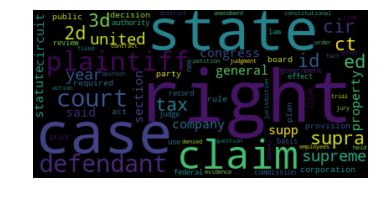

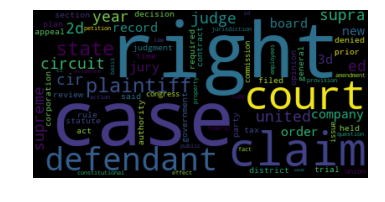

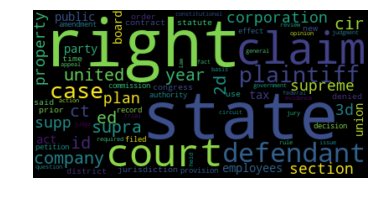

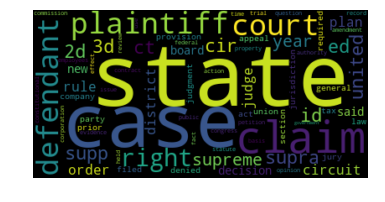

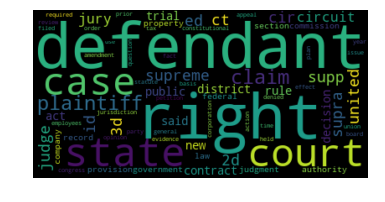

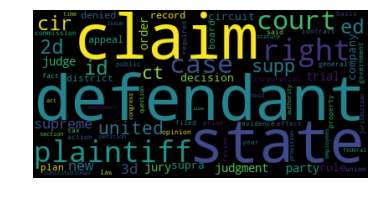

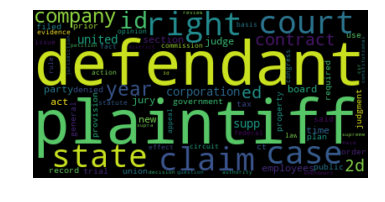

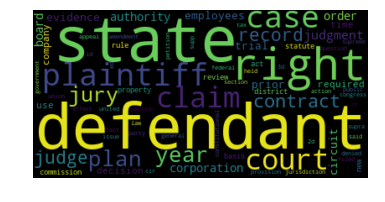

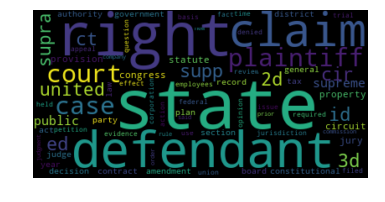

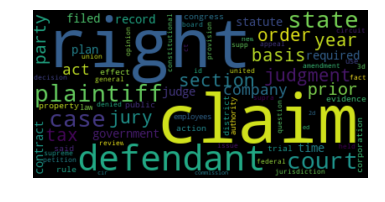

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud

n_topics = [2, 5, 10]
no_top_words = 10
for n in n_topics:
    print("LDA with {} topics".format(n))
    lda = LDA(n_components=n)
    Y = lda.fit(Xtf)
    # Print topics. 
    for topic in lda.components_:
        top_words = " ".join([Xtf_names[i] for i in topic.argsort()])
        #print("Topic {}:{}".format(topic_idx, [Xtf_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        # Create word cloud. 
        wordcloud = WordCloud().generate(top_words)
        # Display the generated image:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

Replicate your sklearn logistic regression model (no hidden layers, L2 regularization, and softmax output layer) in Keras or some other deep learning library. Compare performance. Now add two hidden layers, dropout, and batch normalization. Compare performance.

In [27]:
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.utils import to_categorical

# Create training and test frame. 
x_train, x_test, y_train, y_test = train_test_split(trigram_meta_df, 
                                                    cases_meta_df['case_reversed'], 
                                                    test_size=0.2)

# Sklearn.  
model = LogisticRegression(solver="liblinear").fit(x_train, y_train)
score_train = model.score(x_train, y_train)
score_test  = model.score(x_test, y_test)
print("SK-LEARN")
print("Train: {}, Test: {}".format(score_train, score_test))

# Keras.
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)
input_dim  = x_train.shape[1]
model = Sequential() 
model.add(Dense(2, input_dim=input_dim, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) 
model.fit(x_train, y_train, 
          batch_size=10,epochs=20, verbose=0,
          validation_data=(x_test, y_test)) 
score_train = model.evaluate(x_train, y_train, verbose=0) 
score_test  = model.evaluate(x_test, y_test, verbose=0) 
print("KERAS")
print("Train: {}, Test: {}".format(score_train[1], score_test[1]))

Using TensorFlow backend.


SK-LEARN
Train: 1.0, Test: 0.4444444444444444
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
KERAS
Train: 1.0, Test: 0.4722222222222222
